## Analysing textual features

In [1]:
import keras
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

Using TensorFlow backend.


In [2]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [3]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 500 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

In [4]:
DOMAIN = 'netbeans'
DIR = 'data/processed/{}'.format(DOMAIN)
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))

In [5]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, '{}_pairs.csv'.format(DOMAIN)))
baseline = Baseline(DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [6]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

Creating the buckets...


In [7]:
experiment.load_ids()

Reading bug ids


In [8]:
len(baseline.bug_ids)

216715

In [9]:
experiment.load_bugs()

In [10]:
issues_by_buckets = experiment.get_buckets_for_bugs()

In [11]:
%%time

baseline.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')

Reading train data
Reading bug ids
CPU times: user 2min 34s, sys: 856 µs, total: 2min 34s
Wall time: 2min 34s


In [12]:
title_corpus = [baseline.bug_set[i]['title'][:MAX_SEQUENCE_LENGTH_T] for i in tqdm(baseline.bug_ids)]
description_corpus = [baseline.bug_set[i]['description'][:MAX_SEQUENCE_LENGTH_D] for i in tqdm(baseline.bug_ids)]

100%|██████████| 216715/216715 [00:00<00:00, 1456461.03it/s]


In [13]:
title_length = [len(baseline.bug_set[i]['title'].split(' ')) for i in tqdm(baseline.bug_ids)]
description_length = [len(baseline.bug_set[i]['description'].split(' ')) for i in tqdm(baseline.bug_ids)]

100%|██████████| 216715/216715 [00:01<00:00, 164952.35it/s]


          short_desc
count  216715.000000
mean        8.636749
std         4.267743
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        86.000000
         description
count  216715.000000
mean      166.702176
std       847.603985
min         1.000000
25%        35.000000
50%        65.000000
75%       115.000000
max     22078.000000


Text(0.5, 0, 'número de tokens')

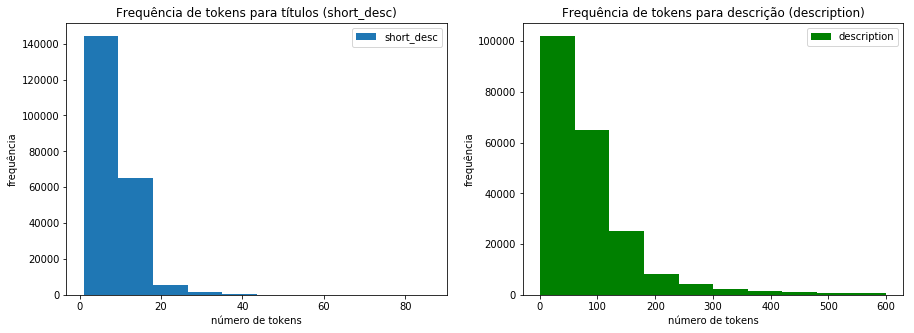

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# Title
df_title = pd.DataFrame(title_length, columns=['short_desc'])
print(df_title.describe())
ax = df_title.plot.hist(ax=axes[0])
ax.set_title('Frequência de tokens para títulos (short_desc)')
ax.set_ylabel('frequência')
ax.set_xlabel('número de tokens')
# Description
df_desc = pd.DataFrame(description_length, columns=['description'])
print(df_desc.describe())
df_desc = df_desc[df_desc['description'] <= 600]
ax = df_desc.plot.hist(color='g', ax=axes[1])
ax.set_title('Frequência de tokens para descrição (description)')
ax.set_ylabel('frequência')
ax.set_xlabel('número de tokens')

In [15]:
def filter_words(corpus, callback):
    corpus_filtered_words = [row.split(' ') for row in corpus]
    corpus_in_words = []
    for row in corpus_filtered_words:
        corpus_in_words += [word for word in row if callback(len(word))]
    return corpus_in_words

### Word cloud title

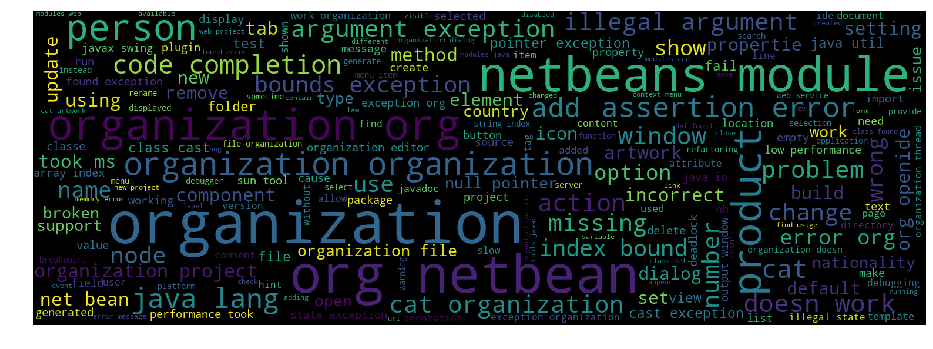

CPU times: user 6.16 s, sys: 249 ms, total: 6.41 s
Wall time: 6.24 s


In [16]:
%%time

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(" ".join(title_corpus))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word cloud description

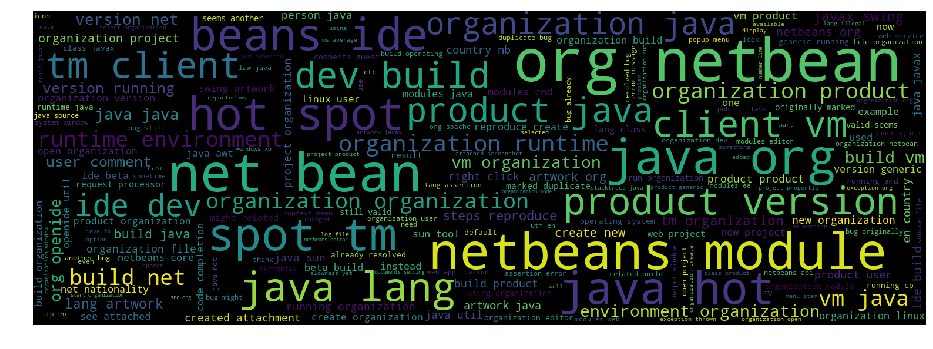

CPU times: user 25 s, sys: 777 ms, total: 25.7 s
Wall time: 25.6 s


In [17]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(" ".join(description_corpus))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Word cloud 2 words in title

In [18]:
corpus_2_words = [row.split(' ') for row in title_corpus]
title_corpus_2_words = []
for row in corpus_2_words:
    title_corpus_2_words += [word for word in row if len(word) == 2]

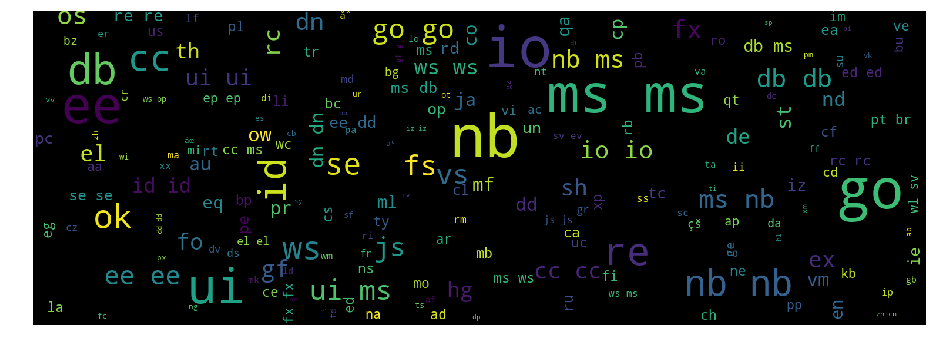

CPU times: user 991 ms, sys: 144 ms, total: 1.14 s
Wall time: 985 ms


In [19]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(' '.join(title_corpus_2_words))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word cloud 2 words in description

In [20]:
corpus_2_words = [row.split(' ') for row in description_corpus]
desc_corpus_2_words = []
for row in corpus_2_words:
    desc_corpus_2_words += [word for word in row if len(word) == 2]

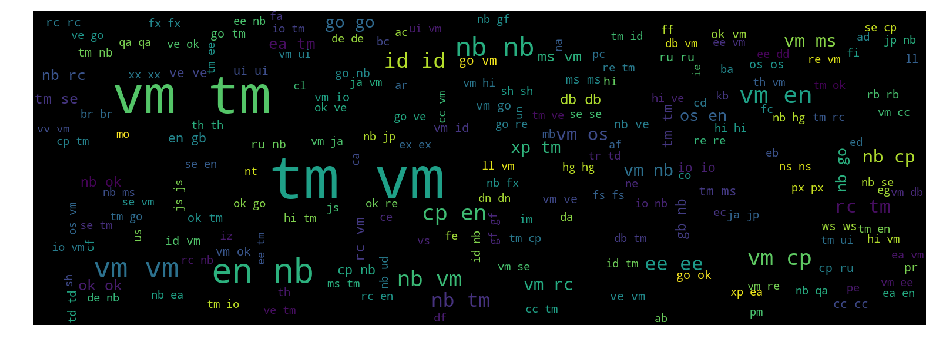

CPU times: user 2.31 s, sys: 140 ms, total: 2.45 s
Wall time: 2.3 s


In [21]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(' '.join(desc_corpus_2_words))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word cloud 1 word in title

In [22]:
corpus_1_word = [row.split(' ') for row in title_corpus]
title_corpus_1_word = []
for row in corpus_1_word:
    title_corpus_1_word += [word for word in row if len(word) == 1]

In [23]:
freq_words = {}
for word in title_corpus_1_word:
    if word not in freq_words:
        freq_words[word] = 0
        
    freq_words[word] += 1

Text(0.5, 0, 'frequency')

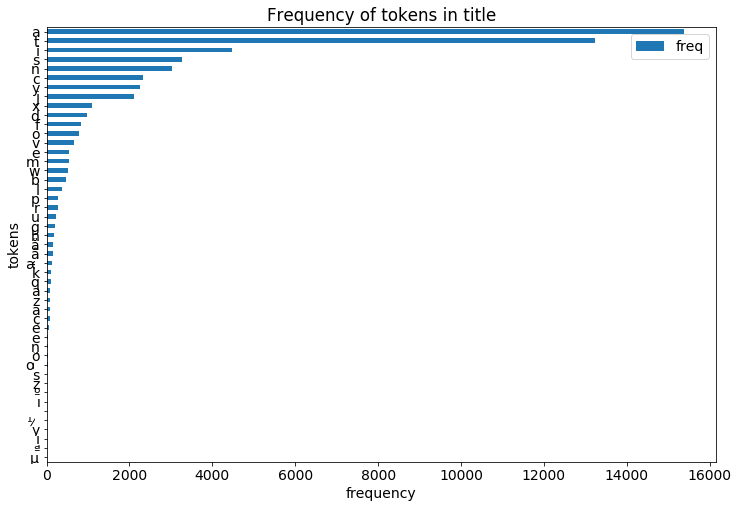

In [24]:
MEDIUM_SIZE = 16
SMALL_SIZE = 14

plt.rc('font', size=SMALL_SIZE)

df = pd.DataFrame(freq_words, columns=list(freq_words), index=range(len(freq_words))).transpose()[[0]]
df.columns = ['freq']
ax = df.sort_values('freq', ascending=True).plot.barh(figsize=(12, 8))
ax.set_title('Frequency of tokens in title')
ax.set_ylabel('tokens')
ax.set_xlabel('frequency')

### Word cloud 1 word in title

In [25]:
corpus_1_word = [row.split(' ') for row in description_corpus]
desc_corpus_1_word = []
for row in corpus_1_word:
    desc_corpus_1_word += [word for word in row if len(word) == 1]

In [26]:
freq_words = {}
for word in desc_corpus_1_word:
    if word not in freq_words:
        freq_words[word] = 0
        
    freq_words[word] += 1

Text(0.5, 0, 'frequency')

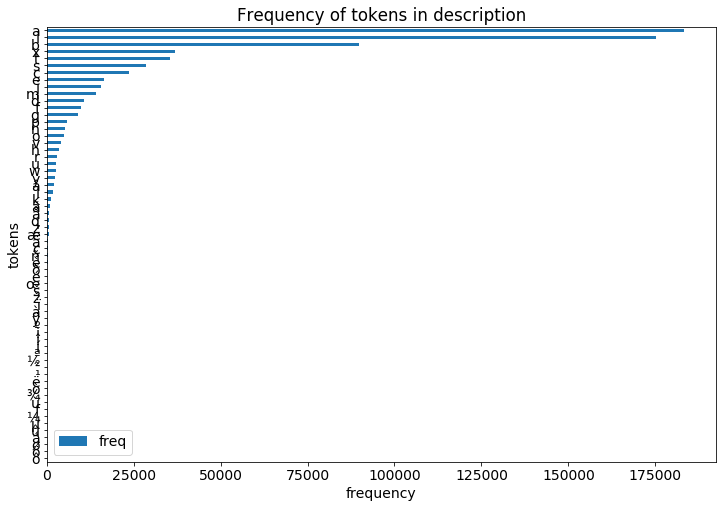

In [27]:
MEDIUM_SIZE = 16
SMALL_SIZE = 14

plt.rc('font', size=SMALL_SIZE)

df = pd.DataFrame(freq_words, columns=list(freq_words), index=range(len(freq_words))).transpose()[[0]]
df.columns = ['freq']
ax = df.sort_values('freq', ascending=True).plot.barh(figsize=(12, 8))
ax.set_title('Frequency of tokens in description')
ax.set_ylabel('tokens')
ax.set_xlabel('frequency')

### Distribution of words in title

In [28]:
dist_word = [row.split(' ') for row in title_corpus]
size_tokens = []
for row in dist_word:
    size_tokens += [len(word) for word in row]

In [29]:
from collections import Counter
freq_tokens = Counter(size_tokens)

Text(0.5, 0, 'token_size')

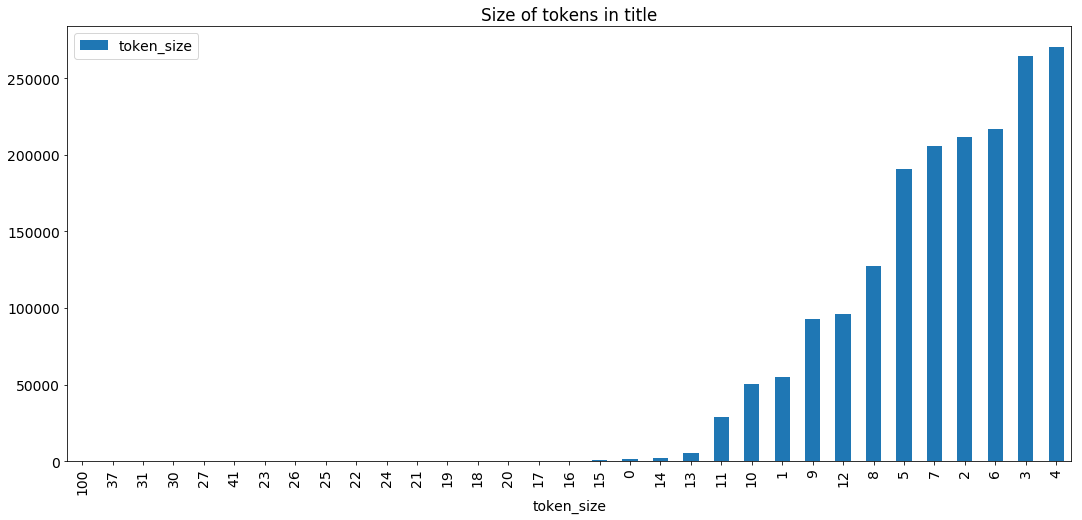

In [30]:
df = pd.DataFrame(freq_tokens, index=range(len(freq_tokens))).transpose()[[0]]
df.columns = ['token_size']
ax = df.sort_values('token_size', ascending=True).plot.bar(figsize=(18, 8))
ax.set_title('Size of tokens in title')
ax.set_xlabel('token_size')

In [31]:
def filter_by_words_title(token_size):
    return token_size == 20

corpus_filtered = filter_words(title_corpus, filter_by_words_title)
len(corpus_filtered)

102

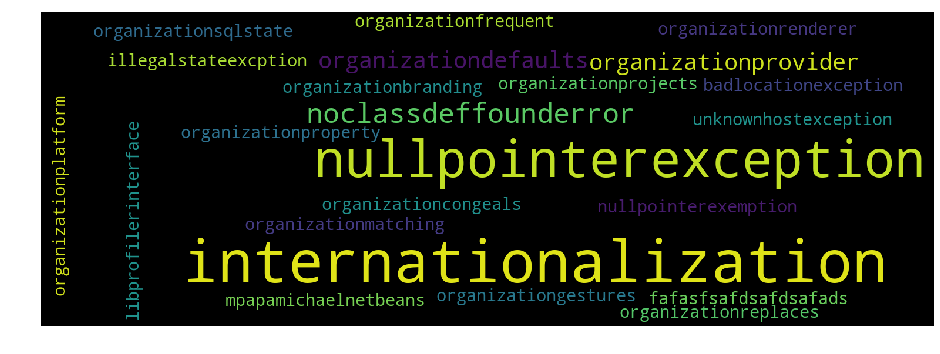

CPU times: user 338 ms, sys: 121 ms, total: 458 ms
Wall time: 314 ms


In [32]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(' '.join(corpus_filtered))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Distribution of words in description

In [33]:
dist_word = [row.split(' ') for row in description_corpus]
size_tokens = []
for row in dist_word:
    size_tokens += [len(word) for word in row]

In [34]:
from collections import Counter
freq_tokens = Counter(size_tokens)

Text(0.5, 0, 'token_size')

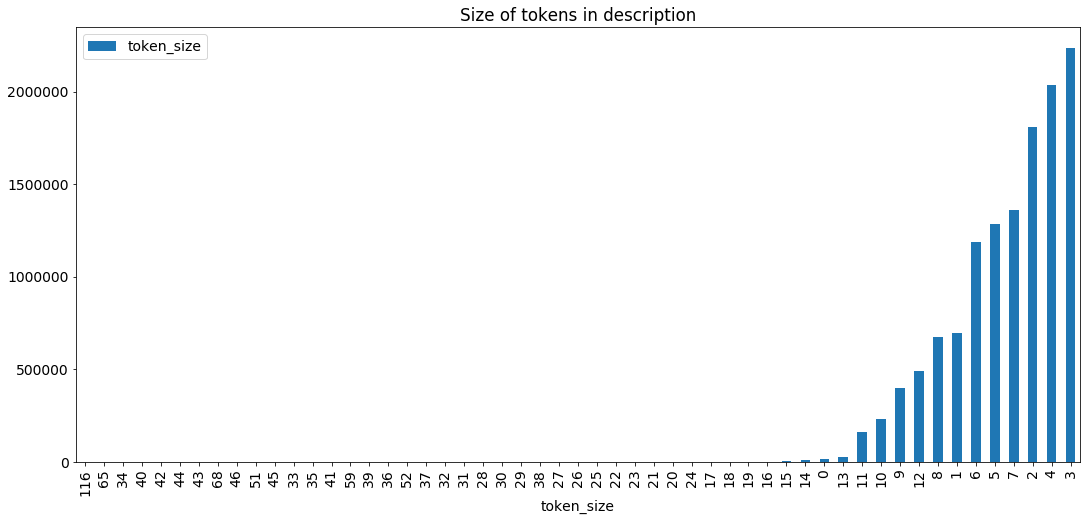

In [35]:
df = pd.DataFrame(freq_tokens, index=range(len(freq_tokens))).transpose()[[0]]
df.columns = ['token_size']
ax = df.sort_values('token_size', ascending=True).plot.bar(figsize=(18, 8))
ax.set_title('Size of tokens in description')
ax.set_xlabel('token_size')

In [36]:
def filter_by_words_desc(token_size):
    return token_size == 5

corpus_filtered = filter_words(description_corpus, filter_by_words_desc)
len(corpus_filtered)

1284370

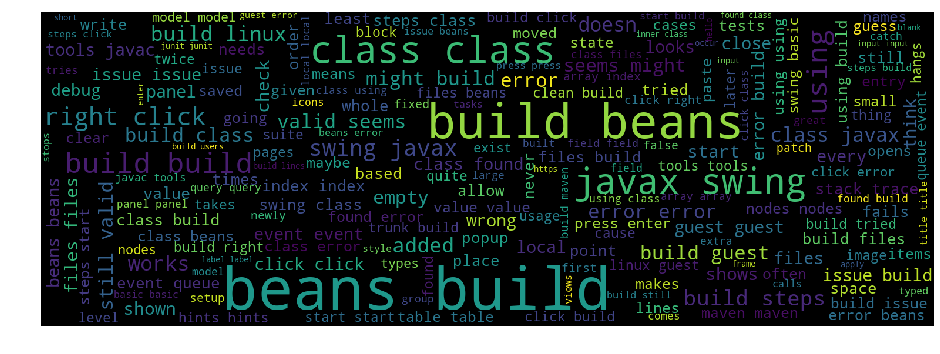

CPU times: user 3.42 s, sys: 144 ms, total: 3.56 s
Wall time: 3.41 s


In [37]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(' '.join(corpus_filtered))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Visualize a random bug

In [38]:
bug_selected = np.random.choice(baseline.bug_ids, 1)[0]

bug = baseline.bug_set[bug_selected]

bug

{'bug_severity': '1\n',
 'bug_status': '2\n',
 'component': '136\n',
 'creation_ts': '2008-07-17 19:07:00 +0000',
 'delta_ts': '2008-08-01 17:34:15 +0000',
 'description': 'when opening a schema that has been closed not opened automatically after creating a new one the schema view is empty system product version net beans ide dev build java java hot spot tm organization b product os x version running on x person en country nb steps open a schema that s all',
 'description_word': array([  66,  605,   16,  282,   65,  195,  456,  804,   28,  295, 1058,
         148,  645,   16,   71,  266,    9,  282,  145,   15,  428,  141,
           8,   72,   47,   51,   58,   87,   37,    2,    2,  107,  108,
         104,    4,   45,    8,  721,   53,   72,  150,   30,   53,   10,
         346,  138,   82,  273,   80,   16,  282,   65,  132,  120,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,

#### Total missing values after preprocessing

In [39]:
bugs_empty_desc = [idx for idx in list(baseline.bug_set) if baseline.bug_set[idx]['description'] == '']
bugs_empty_title = [idx for idx in list(baseline.bug_set) if baseline.bug_set[idx]['title'] == '']

In [40]:
len(bugs_empty_title), len(bugs_empty_desc)

(1, 506)

In [41]:
df = pd.read_csv(DATASET)
df[df['bug_id'].isin(bugs_empty_desc)]

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
3937,6119,normal,CLOSED,-- Other --,2000-04-04 21:12:00 +0000,2008-12-23 10:51:07 +0000,1.\n2.\n3.,[],P4,platform,INVALID,Closing Editor kills IDE.,3.x
4697,7334,minor,CLOSED,Unsupported,2000-08-09 17:49:00 +0000,2007-09-26 09:14:13 +0000,[1074],[],P4,java,FIXED,ClassElement is not pasted into SourceElement ...,3.x
5050,7692,normal,CLOSED,-- Other --,2000-09-18 13:56:00 +0000,2008-12-23 11:44:11 +0000,[1100],[],P4,platform,INVALID,"IllegalStateException from ""New from template""...",3.x
5057,7696,normal,CLOSED,Unsupported,2000-09-18 15:01:00 +0000,2007-09-26 09:14:13 +0000,[1100],[],P3,java,WORKSFORME,NullPointerException from property editor of m...,3.x
5156,7798,enhancement,CLOSED,Java,2000-10-03 15:49:00 +0000,2002-07-19 15:17:41 +0000,-,[],P4,debugger,FIXED,"""this""-object missing in Variables-tab, CallSt...",3.x
7006,9682,blocker,RESOLVED,collabnet,2001-02-19 12:17:00 +0000,2009-11-08 02:27:19 +0000,[],[],P2,obsolete,INVALID,"Servlet needs extra "" to close out a quote--Is...",3.x
7363,10039,blocker,CLOSED,Generic Infrastructure,2001-03-07 13:14:00 +0000,2003-07-01 14:17:49 +0000,[],[],P3,projects,FIXED,Project save is trying to serialize default fi...,3.x
7501,10172,blocker,CLOSED,Code,2001-03-12 14:50:00 +0000,2003-06-30 18:30:00 +0000,[],[],P3,guibuilder,FIXED,NPE thrown after doubleclik on a component,3.x
7664,10344,blocker,CLOSED,Code,2001-03-15 10:15:00 +0000,2003-06-30 18:30:47 +0000,[],[],P4,guibuilder,FIXED,ComponentInspectorAction should be disabled if...,3.x
7684,10365,blocker,CLOSED,Code,2001-03-15 17:58:00 +0000,2003-06-30 18:31:16 +0000,[],[],P3,guibuilder,FIXED,Test action doesn't work for JInternalFrame form,3.x


In [42]:
len(bugs_empty_desc) / len(baseline.bug_set) * 100.0

0.23348637611609718